# Spectral Analysis using xrft and Pangeo


In this notebook we show how [xrft](https://xrft.readthedocs.io/en/latest/) can be used to do spectral analysis on the LLC4320, which is a global ~1.5km resolution ocean model with tides. 

The notebook has been written to be able to do the analyis on [ocean.pangeo.io](ocean.pangeo.io), which gives users access to some free computational resources. 

Since the data is already present on the ocean pangeo server, most of the analysis goes faster than if trying to access the data from the NASA server. However, since the computational resources are limited some analysis that needs access to lot of data at once can make the notebook crash.

**Contents**

* How to load data from LLC4320
* Plots of some fields
* Power Spectra
* Cross Spectra
* Rotary Spectra
* Spectral transfer rates

In [1]:
# Set to have less messages from distributed
import dask
dask.config.set({"logging.distributed": "error"})

In [2]:
# Setup cluster
from dask.distributed import Client, progress
from dask_kubernetes import KubeCluster
cluster = KubeCluster()
cluster.adapt(minimum=1, maximum=40)
client = Client(cluster)
client

<Client: 'tcp://10.32.16.172:44131' processes=0 threads=0, memory=0 B>

In [11]:
# Load some useful modules 
import numpy as np
import xarray as xr
import xrft
import intake
from xmitgcm import llcreader # use this to convert from faces to lat-lon format. 
from matplotlib import pyplot as plt
import xgcm

%matplotlib inline

In [4]:
# Use intake to access the LLC4320 catalog
cat_url = "https://raw.githubusercontent.com/pangeo-data/pangeo-datastore/master/intake-catalogs/ocean/llc4320.yaml"
cat = intake.Catalog(cat_url)

In [5]:
# Get variables from catalog
sst = cat.LLC4320_SST.to_dask()
sss = cat.LLC4320_SSS.to_dask()
ssh = cat.LLC4320_SSH.to_dask()
u = cat.LLC4320_SSU.to_dask()
v = cat.LLC4320_SSV.to_dask()

In [8]:
ds = xr.merge([ssh, sst, sss, u, v])
ds = llcreader.llcmodel.faces_dataset_to_latlon(ds, metric_vector_pairs=[])
# I believe that converting data to latlon slows things down quite a bit. 
# So for speeding things up try to stick with directly analyzing face. 

In [9]:
# The LLC grid is part of this catalog
coords = cat.LLC4320_grid.to_dask().reset_coords()
coords = llcreader.llcmodel.faces_dataset_to_latlon(coords)

### Data from the region 

In [23]:
# pick a region that is not too close to the poles, here the grid 
# is approximately squarish
sel_area = np.logical_and(np.logical_and(coords.XC>25, coords.XC<45 ),
                           np.logical_and(coords.YC>-55, coords.YC<-49 ))

In [24]:
# Setup grid object for calculus on variables
grid = xgcm.Grid(coords.drop(['k', 'k_p1']), periodic=None)

In [25]:
X = coords.XC.where(sel_area, drop=True)
Y = coords.YC.where(sel_area, drop=True)
Xmean = X.mean(['j'])
Ymean = Y.mean(['i']) # make some approximate X, Y coordinates (we chose a region with approx square grids)

In [26]:
SSH_sel = ds.Eta.where(sel_area, drop=True)
SST_sel = ds.SST.where(sel_area, drop=True)

distributed.scheduler - ERROR - Couldn't gather keys {"('logical_and-0a556d540877a321ba580d11019b63b0', 0, 2)": []} state: ['processing'] workers: []
NoneType: None
distributed.scheduler - ERROR - Workers don't have promised key: [], ('logical_and-0a556d540877a321ba580d11019b63b0', 0, 2)
NoneType: None
distributed.client - WARNING - Couldn't gather 1 keys, rescheduling {"('logical_and-0a556d540877a321ba580d11019b63b0', 0, 2)": ()}


In [27]:
SST_sel.data

dask.array<where, shape=(9030, 494, 960), dtype=float32, chunksize=(1, 494, 960), chunktype=numpy.ndarray>

In [28]:
SSS_sel = ds.SSS.where(sel_area, drop=True)

distributed.scheduler - ERROR - Couldn't gather keys {"('logical_and-0a556d540877a321ba580d11019b63b0', 1, 1)": [], "('logical_and-0a556d540877a321ba580d11019b63b0', 2, 0)": [], "('logical_and-0a556d540877a321ba580d11019b63b0', 1, 3)": []} state: ['processing', 'waiting', 'waiting'] workers: []
NoneType: None
distributed.scheduler - ERROR - Workers don't have promised key: [], ('logical_and-0a556d540877a321ba580d11019b63b0', 1, 1)
NoneType: None
distributed.scheduler - ERROR - Workers don't have promised key: [], ('logical_and-0a556d540877a321ba580d11019b63b0', 2, 0)
NoneType: None
distributed.scheduler - ERROR - Workers don't have promised key: [], ('logical_and-0a556d540877a321ba580d11019b63b0', 1, 3)
NoneType: None
distributed.client - WARNING - Couldn't gather 3 keys, rescheduling {"('logical_and-0a556d540877a321ba580d11019b63b0', 1, 1)": (), "('logical_and-0a556d540877a321ba580d11019b63b0', 2, 0)": (), "('logical_and-0a556d540877a321ba580d11019b63b0', 1, 3)": ()}


In [29]:
U_sel = (grid.interp(ds.U, 'X', boundary='extend')).where(sel_area, drop=True).rename('U')
V_sel = (grid.interp(ds.V, 'Y', boundary='extend')).where(sel_area, drop=True).rename('V')

In [30]:
# calculate surface density
from fastjmd95 import rho
SSD_sel = xr.apply_ufunc(rho, 
                        SSS_sel, SST_sel, 0, 
                        dask='parallelized', output_dtypes=[float,]).rename('SSD')

In [31]:
ds_sel = xr.merge([SSH_sel, SST_sel, SSS_sel, U_sel, V_sel, SSD_sel]
                 ).assign_coords(XC=Xmean, YC=Ymean)

In [32]:
# Load a single time step so that plotting is faster
ds_sel_loaded =  ds_sel.isel(time=0)
ds_sel_loaded.load();

distributed.scheduler - ERROR - Couldn't gather keys {"('getitem-98280fc5f85a28b54c9a57fa7223aa2b', 0, 0)": [], "('getitem-db4949f5c404c72afa6aacf58e6ab8c6', 0, 0)": []} state: ['waiting', 'waiting'] workers: []
NoneType: None
distributed.scheduler - ERROR - Workers don't have promised key: [], ('getitem-98280fc5f85a28b54c9a57fa7223aa2b', 0, 0)
NoneType: None
distributed.scheduler - ERROR - Workers don't have promised key: [], ('getitem-db4949f5c404c72afa6aacf58e6ab8c6', 0, 0)
NoneType: None
distributed.client - WARNING - Couldn't gather 2 keys, rescheduling {"('getitem-98280fc5f85a28b54c9a57fa7223aa2b', 0, 0)": (), "('getitem-db4949f5c404c72afa6aacf58e6ab8c6', 0, 0)": ()}


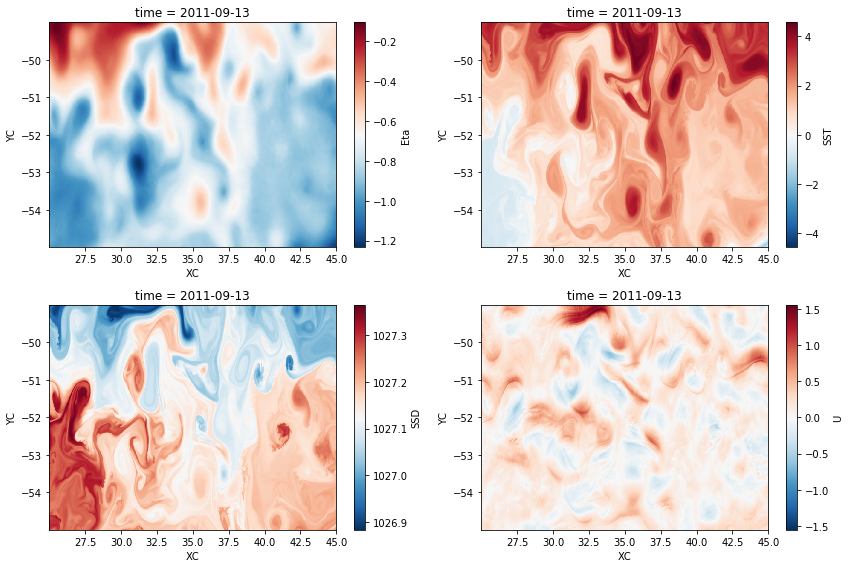

In [33]:
# Some maps
plt.figure(figsize=(12,8))

plt.subplot(221)
ds_sel_loaded.Eta.plot(x='XC', y='YC', cmap='RdBu_r')

plt.subplot(222)
ds_sel_loaded.SST.plot(x='XC', y='YC', cmap='RdBu_r')

plt.subplot(223)
ds_sel_loaded.SSD.plot(x='XC', y='YC', cmap='RdBu_r')

plt.subplot(224)
ds_sel_loaded.U.plot(x='XC', y='YC', cmap='RdBu_r')

plt.tight_layout()

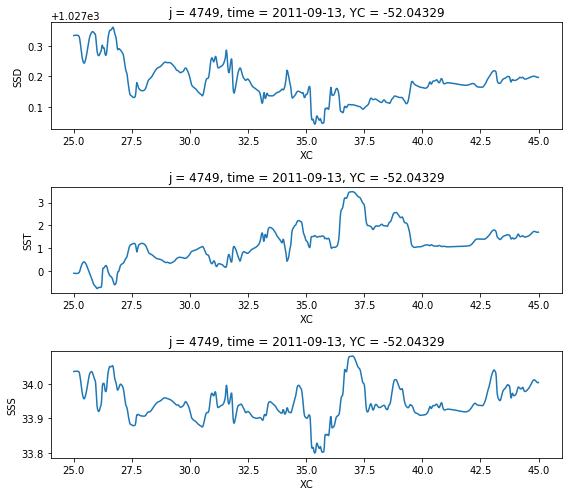

In [34]:
# Some 1D section to see the structure in the data 
plt.figure(figsize=(8,7))
plt.subplot(311)
ds_sel_loaded.SSD.isel(j=250).plot(x='XC' )

plt.subplot(312)
ds_sel_loaded.SST.isel(j=250).plot(x='XC' )

plt.subplot(313)
ds_sel_loaded.SSS.isel(j=250).plot(x='XC' )

plt.tight_layout()

## Power Spectra

### Wavenumber Spectra

In [35]:
# Wavenumber spectra calculated by transforming in the x direction
SSH_k_ps = xrft.power_spectrum(ds_sel_loaded.Eta, 
                               dim=['i'],
                               window=True, 
                               detrend='constant')
SST_k_ps = xrft.power_spectrum(ds_sel_loaded.SST, 
                               dim=['i'],
                               window=True, 
                               detrend='constant')
SSD_k_ps = xrft.power_spectrum(ds_sel_loaded.SSD, 
                               dim=['i'],
                               window=True, 
                               detrend='constant')
U_k_ps = xrft.power_spectrum(ds_sel_loaded.U, 
                               dim=['i'],
                               window=True, 
                               detrend='constant')
V_k_ps = xrft.power_spectrum(ds_sel_loaded.V, 
                               dim=['i'],
                               window=True, 
                               detrend='constant')

# here we used only the loaded data from one time step.
# For the spatial power spectra a single snapshot (over some area) is sufficient for the 
# wavenumber spectra to almost converge

In [36]:
ds_sel_loaded_k_ps = xr.merge([SSH_k_ps.rename('SSH_ps'),
                               SST_k_ps.rename('SST_ps'), 
                               SSD_k_ps.rename('SSD_ps'),
                               U_k_ps.rename('U_ps'),
                               V_k_ps.rename('V_ps')])

In [37]:
# again load for faster plotting.
ds_sel_loaded_k_ps.load()

<xarray.Dataset>
Dimensions:         (freq_i: 960, j: 494)
Coordinates:
  * j               (j) int64 4499 4500 4501 4502 4503 ... 4989 4990 4991 4992
  * freq_i          (freq_i) float64 -0.5 -0.499 -0.4979 ... 0.4969 0.4979 0.499
    freq_i_spacing  float64 0.001042
Data variables:
    SSH_ps          (j, freq_i) float64 2.889e-11 5.789e-11 ... 3.552e-10
    SST_ps          (j, freq_i) float64 4.784e-06 5.128e-06 ... 2.18e-06
    SSD_ps          (j, freq_i) float64 4.995e-09 4.637e-09 ... 2.87e-08
    U_ps            (j, freq_i) float64 1.447e-12 6.506e-12 ... 1.119e-11
    V_ps            (j, freq_i) float64 7.919e-08 5.444e-08 ... 3.288e-07

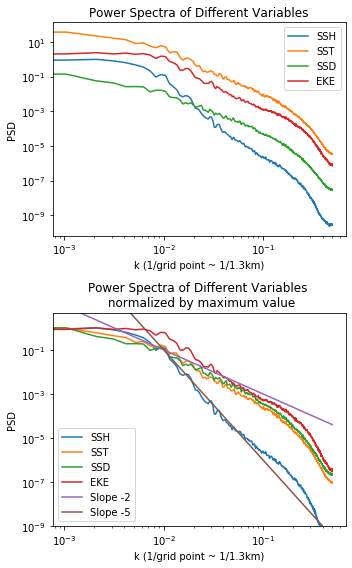

In [38]:
plt.figure(figsize=(5,8))

plt.subplot(211)
(ds_sel_loaded_k_ps.SSH_ps.mean('j')/ds_sel_loaded_k_ps.SSH_ps.mean('j').max()
        ).plot(label='SSH')
ds_sel_loaded_k_ps.SST_ps.mean('j').plot(label='SST')
ds_sel_loaded_k_ps.SSD_ps.mean('j').plot(label='SSD')
(ds_sel_loaded_k_ps.U_ps + ds_sel_loaded_k_ps.V_ps).mean('j').plot(label='EKE')
plt.xscale('log')
plt.yscale('log')
plt.ylabel('PSD')
plt.xlabel('k (1/grid point ~ 1/1.3km)')
plt.legend()
plt.title('Power Spectra of Different Variables')

plt.subplot(212)
(ds_sel_loaded_k_ps.SSH_ps.mean('j')/ds_sel_loaded_k_ps.SSH_ps.mean('j').max()
        ).plot(label='SSH')
(ds_sel_loaded_k_ps.SST_ps.mean('j')/ds_sel_loaded_k_ps.SST_ps.mean('j').max()
        ).plot(label='SST')
(ds_sel_loaded_k_ps.SSD_ps.mean('j')/ds_sel_loaded_k_ps.SSD_ps.mean('j').max()
        ).plot(label='SSD')
((ds_sel_loaded_k_ps.U_ps + ds_sel_loaded_k_ps.V_ps).mean('j')/
(ds_sel_loaded_k_ps.U_ps + ds_sel_loaded_k_ps.V_ps).mean('j').max()
    ).plot(label='EKE')

plt.plot(ds_sel_loaded_k_ps.freq_i, 1e-5*ds_sel_loaded_k_ps.freq_i**-2, label='Slope -2')
plt.plot(ds_sel_loaded_k_ps.freq_i, 1e-11*ds_sel_loaded_k_ps.freq_i**-5, label='Slope -5')
plt.ylim([1e-9, 5])
plt.xscale('log')
plt.yscale('log')
plt.ylabel('PSD')
plt.xlabel('k (1/grid point ~ 1/1.3km)')
plt.title('Power Spectra of Different Variables \n normalized by maximum value')
plt.legend()
plt.tight_layout()


#### Check how isotropic things are

Since we only plotted 

In [90]:
# Wavenumber spectra, check how isotropic things are

SSH_ps_x = xrft.power_spectrum(ds_sel_loaded.Eta,
                             dim=['i'],
                             window=True, 
                             detrend='constant').compute()

SSH_ps_y = xrft.power_spectrum(ds_sel_loaded.Eta,
                             dim=['j'],
                             window=True, 
                             detrend='constant').compute()

In [91]:
# since the dimensions are just grid point indices
# we need to rescale k axis
dx=1.3

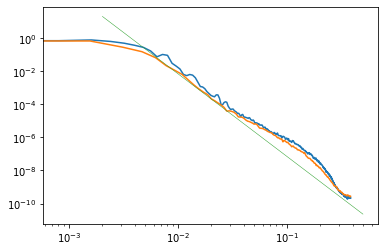

In [92]:
plt.plot(SSH_ps_x.freq_i/dx, SSH_ps_x.mean(['j']))
plt.plot(SSH_ps_y.freq_j/dx, SSH_ps_y.mean(['i']))
plt.plot(SSH_ps_y.freq_j, 0.7e-12*SSH_ps_y.freq_j**-5, linewidth=0.5)

plt.xscale('log')
plt.yscale('log')

### Frequency Spectra

It is much more expensive to estimate the frequency spectra because the data is chunked along the time dimension, and so estimating any quantity along this direction requires reading in of a lot of files. 

In [27]:
SSH_sel.data

dask.array<where, shape=(9030, 494, 960), dtype=float32, chunksize=(1, 494, 960), chunktype=numpy.ndarray>

In [57]:
# Take a smaller subset of the data for the frequency spectra
# Here we take a much smaller subset because we have no expectations 
# of the frequency spectra to vary signficantly spatially
subset_factor = 30

SSH_sel_subset = (SSH_sel.isel(j=slice(0 ,None, subset_factor),
                              i=slice(0 ,None, subset_factor), 
                              time=slice(0,15*24)) # 45 days of data selected
                 .stack(point=['i','j'])
                 .chunk({'time': 15*24, 'point':544}))

In [67]:
V_sel_subset = (V_sel.isel(j=slice(0 ,None, subset_factor),
                              i=slice(0 ,None, subset_factor), 
                              time=slice(0,15*24)) # 45 days of data selected
                 .stack(point=['i','j'])
                 .chunk({'time': 15*24, 'point':544}))

In [58]:
SSH_sel_subset.data

dask.array<rechunk-merge, shape=(360, 544), dtype=float32, chunksize=(360, 544), chunktype=numpy.ndarray>

In [59]:
# load the data set, since the selected subset is so small
# however, beware that this step can sometimes kill workers (sadly :( )
SSH_sel_subset.load();

In [68]:
V_sel_subset.load();

In [62]:
SSH_ps_t = xrft.power_spectrum(SSH_sel_subset, dim=['time'],
                           window=True, detrend='constant')

In [69]:
V_ps_t = xrft.power_spectrum(V_sel_subset, dim=['time'],
                           window=True, detrend='constant')

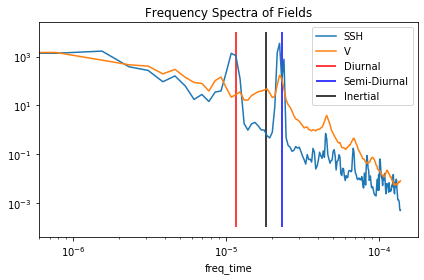

In [88]:
f = 2*2*np.pi/24/3600*np.sin(-52*np.pi/180)

SSH_ps_t.mean(['point']).plot(label='SSH')
V_ps_t.mean(['point']).plot(label='V')

plt.vlines([1/86400], 1e-4, 1e4, label='Diurnal', colors='r')
plt.vlines([1/43200], 1e-4, 1e4, label='Semi-Diurnal', colors='b')
plt.vlines([ -f/2/np.pi], 1e-4, 1e4, label='Inertial', colors='k')

plt.legend()
plt.xscale('log')
plt.yscale('log')

plt.title('Frequency Spectra of Fields')

plt.tight_layout()

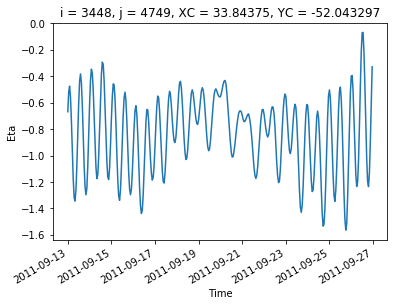

In [15]:
# Plot a short time series surface map
SSH_sel.isel(i=280, j=250).isel(time=slice(0,14*24)).plot()

Follow the algorithm from https://gist.github.com/rabernat/fd2522f1937a43f49ac0423d35915648

### Freq-wavenumber Spectra

In [46]:
V_sub_sel = (V_sel.isel(time=slice(0,120*24), i=slice(0,480), j=slice(0,494,10))
             .chunk({'time':480, 'i':120, 'j':10})
            )

In [47]:
V_sub_sel

<xarray.DataArray 'mul-be72df72ae2714b5fa2a46490d1bbfd5' (time: 2880, j: 50, i: 480)>
dask.array<rechunk-merge, shape=(2880, 50, 480), dtype=float32, chunksize=(480, 10, 120), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2011-09-13 ... 2012-01-10T23:00:00
  * j        (j) int64 4499 4509 4519 4529 4539 ... 4949 4959 4969 4979 4989
  * i        (i) int64 3168 3169 3170 3171 3172 ... 3643 3644 3645 3646 3647

In [48]:
V_sub_sel_ps_xt =  xrft.power_spectrum(V_sub_sel, dim=['time','i'],
                           window=True, detrend='constant',
                           chunks_to_segments=True)

In [49]:
V_sub_sel_ps_xt_av =V_sub_sel_ps_xt.mean(dim=['time_segment', 'i_segment','j'])

In [50]:
V_sub_sel_ps_xt_av

<xarray.DataArray 'rechunk-merge-7d3fd87bc33448baa7f539f07bfb707d' (freq_time: 480, freq_i: 120)>
dask.array<mean_agg-aggregate, shape=(480, 120), dtype=float64, chunksize=(480, 120), chunktype=numpy.ndarray>
Coordinates:
  * freq_time          (freq_time) float64 -0.0001389 -0.0001383 ... 0.0001383
  * freq_i             (freq_i) float64 -0.5 -0.4917 -0.4833 ... 0.4833 0.4917
    freq_time_spacing  float64 5.787e-07
    freq_i_spacing     float64 0.008333

In [51]:
V_sub_sel_ps_xt_av_p = V_sub_sel_ps_xt_av.persist(retries=10)

In [52]:
V_sub_sel_ps_xt_av_p.load()

<xarray.DataArray 'rechunk-merge-7d3fd87bc33448baa7f539f07bfb707d' (freq_time: 480, freq_i: 120)>
array([[1.04107227e-08, 1.12789566e-08, 1.19001448e-08, ...,
        1.31518813e-08, 1.19001448e-08, 1.12789566e-08],
       [1.28444825e-08, 1.30603867e-08, 1.15295843e-08, ...,
        1.33477105e-08, 1.32307147e-08, 1.27799914e-08],
       [1.26221954e-08, 1.20858038e-08, 1.23950121e-08, ...,
        1.53392244e-08, 1.39019868e-08, 1.25169578e-08],
       ...,
       [1.21799457e-08, 1.21401537e-08, 1.13502246e-08, ...,
        1.37071862e-08, 1.36449215e-08, 1.26493934e-08],
       [1.26221954e-08, 1.25169578e-08, 1.39019868e-08, ...,
        1.33695028e-08, 1.23950121e-08, 1.20858038e-08],
       [1.28444825e-08, 1.27799914e-08, 1.32307147e-08, ...,
        1.14710503e-08, 1.15295843e-08, 1.30603867e-08]])
Coordinates:
  * freq_time          (freq_time) float64 -0.0001389 -0.0001383 ... 0.0001383
  * freq_i             (freq_i) float64 -0.5 -0.4917 -0.4833 ... 0.4833 0.4917
    freq_time_spacing  float64 5.787e-07
    freq_i_spacing     float64 0.008333

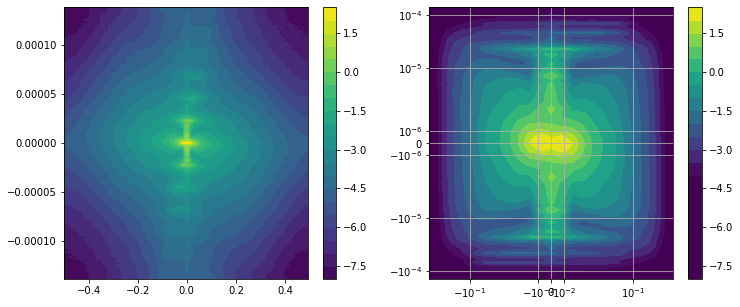

In [80]:
plt.figure(figsize=(12,5))

plt.subplot(121)
plt.contourf(V_sub_sel_ps_xt_av_p.freq_i, V_sub_sel_ps_xt_av_p.freq_time, 
             np.log10(V_sub_sel_ps_xt_av_p), levels=20 )
#plt.xscale('symlog', linthreshx=1e-2)
#plt.yscale('symlog', linthreshy=1e-6)
plt.colorbar()

plt.subplot(122)
plt.contourf(V_sub_sel_ps_xt_av_p.freq_i, V_sub_sel_ps_xt_av_p.freq_time, 
             np.log10(V_sub_sel_ps_xt_av_p), levels=20 , vmin=-4)
plt.xscale('symlog', linthreshx=5e-2)
plt.yscale('symlog', linthreshy=5e-6)
plt.colorbar()
plt.grid()
#plt.xlim([-1 , 1])
#plt.ylim([-1e-4 , 1e-4])

### Cross Spectra
- Velocity*Temp
- Velocity*Salt

In [81]:
T_sel = ds.SST.where(sel_area, drop=True)

In [94]:
VT_cs_x = xrft.cross_spectrum(V_sel, T_sel, dim=['i'], 
                              window=True, detrend='constant')

In [83]:
VT_cs_x

<xarray.DataArray (time: 9030, j: 494, freq_i: 576)>
dask.array<truediv, shape=(9030, 494, 576), dtype=float64, chunksize=(1, 494, 576), chunktype=numpy.ndarray>
Coordinates:
  * time            (time) datetime64[ns] 2011-09-13 ... 2012-09-23T05:00:00
  * j               (j) int64 4499 4500 4501 4502 4503 ... 4989 4990 4991 4992
  * freq_i          (freq_i) float64 -0.5 -0.4983 -0.4965 ... 0.4965 0.4983
    freq_i_spacing  float64 0.001736

In [86]:
VT_cs_x_av = VT_cs_x.isel(time=slice(0,180*24,10*24), j=slice(0, None, 20)
                         ).mean(['j','time'])

In [88]:
VT_cs_x_av.load()

<xarray.DataArray (freq_i: 576)>
array([ 2.08741456e-07,  1.13261884e-07,  3.29792093e-11,  1.77251449e-08,
        6.53104047e-08,  5.26551148e-08,  8.19354157e-08,  6.79615172e-08,
        3.60189860e-08, -1.71148798e-08, -4.03137028e-08, -2.39507386e-08,
       -3.34472410e-09, -9.93005791e-08, -1.28494899e-07, -6.15795701e-08,
       -7.06337038e-08, -1.66304398e-07, -2.05789093e-07, -1.47763212e-07,
        1.09440008e-08, -1.18444811e-07, -1.55210564e-07, -4.90924000e-08,
       -5.51424414e-08, -2.30156527e-07, -2.36628474e-07, -1.53611233e-07,
       -1.32724652e-07, -3.28095821e-08,  7.73688318e-09, -6.44385635e-08,
       -6.44785764e-09,  8.74035847e-08,  1.40607252e-07,  1.58300038e-07,
       -8.31807181e-08, -2.13104044e-07, -8.77573328e-08, -1.46512558e-07,
       -1.63464055e-07,  7.44596824e-08, -7.17491132e-09, -3.84842969e-07,
       -4.01229687e-07, -1.95799264e-07,  2.83094402e-08,  2.22057600e-07,
        1.09837539e-07,  9.10897264e-08,  1.91913738e-08, -8.35971744e-08,
       -1.77367013e-07, -3.56596086e-08, -1.52469358e-07, -2.06130728e-07,
       -1.60409504e-07, -2.25319146e-07, -4.44805900e-07, -5.47772724e-07,
       -5.54598058e-07, -4.57741821e-07, -2.53600605e-07, -2.70625098e-07,
       -4.79964677e-07, -2.12262410e-07,  1.46338593e-07, -2.03329451e-08,
       -3.65098872e-07, -7.12702904e-08, -3.14256330e-07, -4.37030988e-07,
       -4.04077388e-07, -6.06398905e-07, -3.82496456e-07, -3.14422216e-07,
       -3.95744781e-07, -2.63142790e-07, -7.45059258e-07, -4.66779470e-07,
       -2.12851105e-07, -2.55924213e-07, -7.38339619e-07, -2.60162813e-07,
       -1.49245254e-06, -6.89158735e-07, -8.84920948e-08, -7.88032891e-07,
       -4.64507834e-07,  1.23944152e-06, -8.54752006e-08, -3.97394290e-07,
       -4.62450726e-07, -3.97979427e-07, -1.10515663e-06, -1.35708755e-06,
       -3.00030080e-07, -9.65400870e-07, -1.43061055e-06,  5.01643530e-07,
       -1.92643486e-06, -1.39721507e-06, -1.18606221e-06, -2.37006724e-06,
       -2.48813520e-06, -2.89962179e-06, -3.44373663e-06, -3.94149508e-06,
       -2.59626165e-06, -3.09984954e-06, -2.86513474e-06, -3.29105732e-06,
       -4.64811918e-06, -2.28090595e-06, -1.26755951e-06, -1.67556395e-06,
       -9.31950425e-07, -7.64626347e-07, -2.78344063e-06, -4.48441197e-06,
       -2.94449491e-06, -2.90152939e-06, -2.38272140e-06, -8.47941703e-07,
       -2.23893248e-06, -1.42550259e-06, -5.63045347e-06, -6.25855418e-06,
       -4.89220199e-06, -3.12271583e-06, -2.92447327e-06, -5.90745751e-06,
       -1.93665420e-06, -6.54512403e-06, -7.42265445e-06, -5.26109767e-06,
       -3.19516841e-06, -1.58973073e-06, -5.62647674e-06, -9.05034107e-06,
       -8.00111430e-06, -1.15061552e-05, -8.02549042e-06, -8.46006479e-06,
       -1.31228999e-05, -1.05435592e-05, -1.56171200e-05, -8.94096753e-06,
       -1.27246049e-05, -8.35084566e-06, -1.74440550e-05, -1.32923387e-05,
       -1.79591144e-05, -1.67068184e-05, -1.47187381e-05, -1.55091343e-05,
       -2.14741379e-05, -1.89529370e-05, -8.40388108e-06, -1.77265479e-05,
       -2.89099841e-05, -2.03980351e-05, -9.91859012e-06, -6.89038284e-06,
       -1.49915412e-05, -1.32054154e-05, -1.70459146e-05, -1.77393529e-05,
       -2.22290032e-05, -2.38798703e-05, -3.15294877e-05, -3.21730573e-05,
       -2.16902920e-05, -4.19188907e-05, -4.74845724e-05, -3.47629487e-05,
       -4.00481292e-05, -5.44412979e-05, -6.56339824e-05, -6.19106766e-05,
       -3.75172101e-05, -1.87218742e-05, -3.84276257e-06, -2.28268562e-05,
       -5.21643672e-05, -7.99286441e-05, -6.33309991e-05, -7.21203926e-05,
       -4.06829297e-05, -5.47238271e-05, -7.89294576e-05, -7.71470059e-05,
       -5.20447112e-05, -5.48989749e-05, -7.22297387e-05, -7.76944542e-05,
       -8.41680163e-05, -7.88424812e-05, -1.28664346e-04, -7.89386017e-05,
       -6.17846180e-05, -4.75263421e-05, -8.51185873e-05, -7.05708173e-05,
       -4.67180009e-05, -8.28357783e-05, -1.24902427e-04, -1.05391213e-04,
       -1.05163834e-04, -7.88227869e-05, -7.34711188e-05, -7.726714

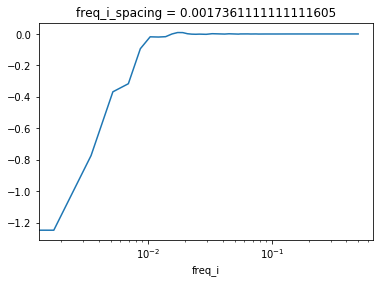

In [91]:
VT_cs_x_av.plot()
plt.xscale('log')

### Rotary Spectra
Calculate the rotary spectra for the velocity, which separates the cyclonic and anticyclonic motions. The inertial oscillations show up only on one side of the spectrum

In [13]:
subset_factor = 15

In [17]:
U_sel_subset = (U_sel.isel(j=slice(0 ,None, subset_factor),
                              i=slice(0 ,None, subset_factor), 
                              time=slice(0,60*24))
                 .stack(point=['i','j'])
                 .chunk({'time': 480, 'point':1000}))

V_sel_subset = (V_sel.isel(j=slice(0 ,None, subset_factor),
                              i=slice(0 ,None, subset_factor), 
                              time=slice(0,60*24))
                 .stack(point=['i','j'])
                 .chunk({'time': 480, 'point':500}))

In [18]:
Z_sel_subset = U_sel_subset + 1j*V_sel_subset

In [19]:
Z_sel_subset

<xarray.DataArray (time: 1440, point: 1287)>
dask.array<add, shape=(1440, 1287), dtype=complex64, chunksize=(480, 500), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2011-09-13 ... 2011-11-11T23:00:00
  * point    (point) MultiIndex
  - i        (point) int64 3168 3168 3168 3168 3168 ... 3738 3738 3738 3738 3738
  - j        (point) int64 4499 4514 4529 4544 4559 ... 4919 4934 4949 4964 4979

In [20]:
Z_ps_t = xrft.power_spectrum(Z_sel_subset, dim=['time'],
                           window=True, detrend='constant',
                           chunks_to_segments=True)
Z_ps_t

<xarray.DataArray 'rechunk-merge-4120e7bad57ca764c8a963eea30f93ff' (time_segment: 3, freq_time: 480, point: 1287)>
dask.array<truediv, shape=(3, 480, 1287), dtype=float64, chunksize=(1, 480, 500), chunktype=numpy.ndarray>
Coordinates:
  * time_segment       (time_segment) int64 0 1 2
  * freq_time          (freq_time) float64 -0.0001389 -0.0001383 ... 0.0001383
  * point              (point) object (3168, 4499) (3168, 4514) ... (3738, 4979)
    freq_time_spacing  float64 5.787e-07

In [21]:
Z_ps_t_av = Z_ps_t.mean(dim=['time_segment', 'point'])

In [22]:
%time Z_ps_t_av_p = Z_ps_t_av.persist(retries=10)

CPU times: user 12.1 s, sys: 1.14 s, total: 13.2 s
Wall time: 13.1 s


In [23]:
Z_ps_t_av_p.load()

<xarray.DataArray 'rechunk-merge-4120e7bad57ca764c8a963eea30f93ff' (freq_time: 480)>
array([1.79027277e-03, 1.75150808e-03, 1.66965279e-03, 1.66457824e-03,
       1.60948786e-03, 1.58937005e-03, 1.49887274e-03, 1.43946840e-03,
       1.45805697e-03, 1.44038070e-03, 1.44629757e-03, 1.46019459e-03,
       1.39600425e-03, 1.53525084e-03, 1.52211897e-03, 1.53919151e-03,
       1.51453074e-03, 1.41476140e-03, 1.26567049e-03, 1.23117314e-03,
       1.36296284e-03, 1.45981836e-03, 1.40094673e-03, 1.33023526e-03,
       1.40878535e-03, 1.52465276e-03, 1.51755167e-03, 1.57096029e-03,
       1.65224605e-03, 1.67755150e-03, 1.76334209e-03, 1.87703751e-03,
       1.85160951e-03, 1.89865631e-03, 1.99659819e-03, 2.09408689e-03,
       2.22131108e-03, 2.31907682e-03, 2.52655291e-03, 2.64755283e-03,
       2.80944212e-03, 2.93238013e-03, 3.09479329e-03, 3.12560209e-03,
       3.03476338e-03, 2.97273207e-03, 2.85045310e-03, 2.75267587e-03,
       2.68945467e-03, 2.74517752e-03, 2.64873229e-03, 2.51006337e-03,
       2.49475210e-03, 2.46697740e-03, 2.42407872e-03, 2.41019320e-03,
       2.33471784e-03, 2.32434872e-03, 2.36191172e-03, 2.43812477e-03,
       2.49567594e-03, 2.54725958e-03, 2.59741986e-03, 2.66801248e-03,
       2.81710004e-03, 3.03803770e-03, 3.14849926e-03, 3.39495351e-03,
       3.56210865e-03, 3.61629946e-03, 3.84673339e-03, 4.04109906e-03,
       4.50523860e-03, 4.92481736e-03, 5.18621909e-03, 5.61163592e-03,
       5.72529111e-03, 6.05066446e-03, 6.54718050e-03, 6.82488774e-03,
       7.53585721e-03, 8.33870967e-03, 8.68224606e-03, 8.41452603e-03,
       8.14408280e-03, 8.11065559e-03, 8.13688438e-03, 8.22501371e-03,
       8.02954947e-03, 7.59720753e-03, 7.27452172e-03, 7.26010698e-03,
       7.13967628e-03, 7.62108643e-03, 7.35241222e-03, 7.58379370e-03,
       7.57126712e-03, 7.34176228e-03, 6.91658132e-03, 6.89570632e-03,
       7.64546937e-03, 7.93708607e-03, 8.15068751e-03, 8.20532044e-03,
       8.89719980e-03, 1.01141211e-02, 1.06875163e-02, 1.11079981e-02,
       1.18217527e-02, 1.24182034e-02, 1.34497633e-02, 1.52700671e-02,
       1.61781044e-02, 1.70962821e-02, 1.83941350e-02, 2.06568771e-02,
       2.33169032e-02, 2.61679433e-02, 2.85709417e-02, 3.07164212e-02,
       3.49885772e-02, 3.81789068e-02, 3.81080675e-02, 3.55851179e-02,
       3.42764310e-02, 3.46563497e-02, 3.24470908e-02, 3.03090177e-02,
       2.84617335e-02, 2.69092226e-02, 2.52108210e-02, 2.45322806e-02,
       2.32419559e-02, 2.28704909e-02, 2.23120330e-02, 2.13148897e-02,
       2.16640974e-02, 2.22016958e-02, 2.18657963e-02, 2.18638545e-02,
       2.32857078e-02, 2.34410891e-02, 2.50452030e-02, 2.76229769e-02,
       2.87109034e-02, 2.97967255e-02, 3.21940711e-02, 3.50478271e-02,
       3.68559770e-02, 3.91352945e-02, 4.17369716e-02, 4.59136687e-02,
       5.15356721e-02, 5.76635466e-02, 6.56489800e-02, 7.35453713e-02,
       8.09409192e-02, 9.19343893e-02, 1.07126099e-01, 1.26587803e-01,
       1.49161004e-01, 1.64946047e-01, 1.53889627e-01, 1.42122618e-01,
       1.25572667e-01, 1.09957122e-01, 9.44822494e-02, 8.91087902e-02,
       8.57618649e-02, 8.39393144e-02, 8.48073869e-02, 8.47839566e-02,
       8.40307246e-02, 9.78617180e-02, 1.03253878e-01, 1.09573354e-01,
       1.12054417e-01, 1.04935988e-01, 8.89713922e-02, 8.86644722e-02,
       1.11355123e-01, 1.27134478e-01, 1.31803382e-01, 1.27924852e-01,
       1.43367943e-01, 1.72320065e-01, 1.77137107e-01, 1.91811239e-01,
       2.16200467e-01, 2.11499920e-01, 2.18332436e-01, 2.47401923e-01,
       2.60868378e-01, 2.91628382e-01, 2.99219258e-01, 3.53340586e-01,
       4.21965792e-01, 5.10879575e-01, 6.42258599e-01, 8.72138040e-01,
       1.21681895e+00, 2.18949654e+00, 1.80992371e+00, 8.16268580e-01,
       7.45028658e-01, 7.34061668e-01, 7.11729565e-01, 8.22408901e-01,
       8.79216214e-01, 9.68652494e-01, 1.04133136e+00, 1.17713118e+00,
       1.26445556e+00, 1.34065860e+00, 1.50690409e+00, 1.72447710e+00,
       1.78219376e+00, 1.65901161e+00, 1.77707688e+00, 2.21981420e+00,
       3.1

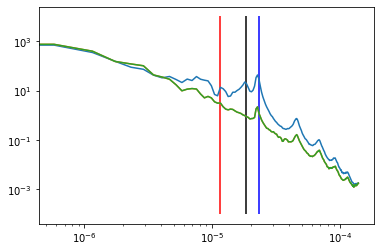

In [38]:
plt.plot(Z_ps_t_av.freq_time, Z_ps_t_av)
plt.plot(-Z_ps_t_av.freq_time, Z_ps_t_av)
plt.plot(-Z_ps_t_av.freq_time, Z_ps_t_av)
plt.vlines([1/86400, 1/43200, -f/2/np.pi], 1e-4, 1e4, 
           colors=['r','b','k'])
plt.xscale('log')
plt.yscale('log')

### Spectral Transfer Terms
- Tracer transfer terms

4